# Tutorial 02 — Render Synthetic Data Cube

Inputs: <br>
`./tutorial01_params.yaml` (created in Tutorial 01; contains `disk` + `chemistry`)

Steps:
 - Load `tutorial01_params.yaml` and parse into `radjax` containers. Create a disk structure.
 - Create synthetic `observation` parameters
 - Build image plane rays (and visualize them!) as a radjax `RayBundle` container
 - Render baseline cube and an additional cube with modified tubulence strength
 - Interactive comparison between the channel maps using the `visualization` module


In [1]:
import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt

from radjax import sensor
from radjax import visualization
from radjax import chemistry as chem

from radjax.models import broken_power_law as disk_model

## Create disk structure from Tutorial 01 YAML

In [2]:
params_path  = "./tutorial01_params.yaml"   # produced in Tutorial 01

disk_params = disk_model.disk_from_yaml(params_path)
chem_params = chem.chemistry_from_yaml_path(params_path)
mol = chem.load_molecular_tables(chem_params)

temperature, v_phi, co_nd, base_disk = disk_model.co_disk_from_params(
    disk_params, chem_params
)

print("Disk fields summary (azimuthal/mirror symmetric fields):")
print(f"  Temperature:        {temperature.shape}, dtype={temperature.dtype}")
print(f"  CO Number Density:  {co_nd.shape}, dtype={co_nd.dtype}")
print(f"  Azimuthal Velocity: {v_phi.shape}, dtype={v_phi.dtype}")

Disk fields summary (azimuthal/mirror symmetric fields):
  Temperature:        (500, 500), dtype=float64
  CO Number Density:  (500, 500), dtype=float64
  Azimuthal Velocity: (500, 500), dtype=float64


## Visualize the radial–vertical structure

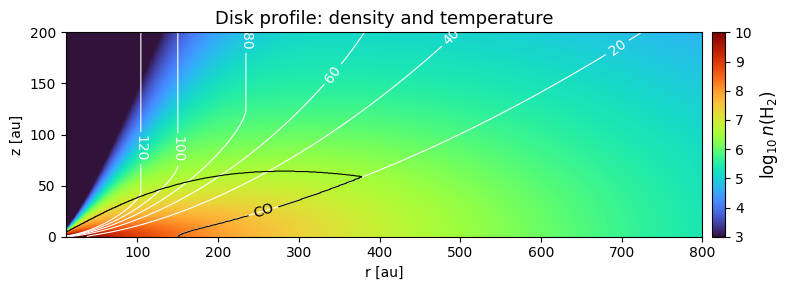

In [3]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,3))
visualization.plot_disk_profile_rz(
    ax, base_disk.r, base_disk.z, base_disk.h2_nd, temperature, co_nd
)
plt.tight_layout()

## Image-plane geometry

Defines the synthetic observation setup:
- **distance**: 80.0 pc (source distance)  
- **fov**: 10.0 arcsec (image-plane extent)  
- **velocity_range**: [2000.0, 10000.0] m/s (min/max velocity channels, receding positive)  
- **vlsr**: 0.0 m/s (systemic velocity)  
- **nray**: 100 (samples along each ray through the disk slab)  
- **incl**: 60.5° (disk inclination)  
- **phi**: 0.0° (azimuthal viewing angle)  
- **posang**: 0.0° (position angle, east of north)  
- **z_width**: 400.0 AU (vertical slab thickness for ray construction)

In [4]:
observation_dict = {
    "name": "tutorial02-synthetic",      # dataset name
    "distance": 80.0,                    # [pc]
    "fov": 10.0,                         # [arcsec]
    "velocity_width_kms": 3.65,          # Spectral width in [km/s]
    "nray": 100,                         # samples along each ray
    "incl": 60.5,                        # [deg]
    "phi": 0.0,                          # [deg]
    "posang": 0.0,                       # [deg] E of N
    "z_width": 400.0,                    # [AU]
}

## Load into `ObservationParams` container

The dictionary is passed to the radjax container to validate types and units.

In [5]:
obs_params = sensor.ObservationParams(**observation_dict)
sensor.print_params(obs_params)

 Dataset name:            tutorial02-synthetic
 Mode:                    SYNTHETIC (toy cube)
--------------------------------------------------
 Distance (pc):              80.00
 Field of view (arcsec):    10.000
 Velocity width (km/s):       3.65
 Velocity bounds (m/s):    -1825.0 →   1825.0
 Center velocity (m/s):       0.00
--------------------------------------------------
 Number of rays:               100
 Inclination (deg):          60.50
 Phi (deg):                   0.00
 Position angle (deg):        0.00
 Slab thickness z_width (AU):   400.00


## Update Tutorial 01 YAML with observation block

We now extend the YAML (originally disk+chemistry only) with this observation and assign the dataset name.

In [6]:
# This will merge the observation block into params and save back to file
sensor.params_to_yaml(obs_params, params_path)
print(f"Updated YAML with observation → {params_path}")

Updated YAML with observation → ./tutorial01_params.yaml


## Build image-plane grid and rays

We now define the image resolution and construct the **ray bundle**:

- **Image resolution**: 200 × 200 pixels  
- **FoV**: taken from `obs_params.fov` (arcsec), spanning `[-FoV/2, +FoV/2]` in both x and y  
- **Meshgrid**: `(x_sky, y_sky)` in arcsec defines the image-plane coordinates  
- **Ray construction**: `sensor.rays_from_params` generates a `RayBundle` object,  
  with each pixel mapped to a ray that intersects the disk slab.  

Each ray stores start and stop coordinates in 3D physical space (AU), sampled along the line of sight.  
The final shape of `rays.coords_xyz` encodes `(ny, nx, nray, 3)`:
- `ny, nx`: spatial image grid  
- `nray`: number of samples along each ray (from `obs_params.nray`)  
- `3`: Cartesian coordinates (x, y, z) in AU

In [7]:
npix = 300
xaxis = yaxis = np.linspace(-obs_params.fov/2, obs_params.fov/2, npix)
x_sky, y_sky = jnp.meshgrid(xaxis, yaxis, indexing="xy")

# Build ray bundle from observation parameters and sky grid
rays = sensor.rays_from_params(obs_params, x_sky, y_sky)
print("Ray coords shape:", rays.coords_xyz.shape)

Ray coords shape: (300, 300, 100, 3)


## Visualize a few rays in the x–z plane

We take a central horizontal cut (fixed **y** at the image midline) and plot several rays:

- **x–z plane**: shows how samples march along the line of sight through the slab
- **Slab bounds**: dashed lines at `z = ± z_width/2` (from `obs_params`)
- **Units**: ray coordinates are in AU (physical space)

Tip: try changing `nray` or `z_width` and rerun to see sampling density/thickness effects, e.g.
```
obs_params = obs_params.replace(z_width=300)
```


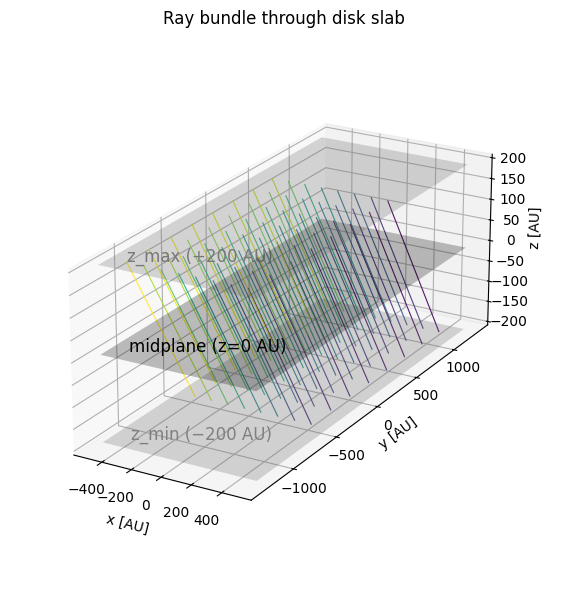

In [8]:
ax = visualization.plot_ray_bundle_3d(rays, obs_params, n_side=8, cmap="viridis")

## Build frequency grid for the camera

We construct `num_freqs=50` channels around the line rest frequency `ν₀`.  
For **synthetic** setups we pass a total spectral span via `velocity_width_kms`.

- **ν₀**: taken from the molecular table (`mol.nu0` in Hz)
- **Width**: `obs_params.velocity_width_kms` (km/s) → converted internally to m/s
- **Output**: `freqs` (Hz), length = 50

In [9]:
freqs = sensor.compute_camera_freqs(
    num_freqs=50,
    width_kms=obs_params.velocity_width_kms,
    nu0=mol.nu0
)

## Sample disk fields along rays

We evaluate the **CO number density**, **temperature**, and **vector velocity** *along each ray* through the slab.

Shapes:
- `velocity_ray`: (ny, nx, nray, 3)
- `nd_ray`, `temperature_ray`: (ny, nx, nray)

In [10]:
nd_ray, temperature_ray, velocity_ray = sensor.sample_symmetric_disk__along_rays(
    rays=rays,
    bbox=base_disk.bbox,
    co_nd=co_nd,
    temperature=temperature,
    v_phi=v_phi,
)
print("nd_ray:", getattr(nd_ray, "shape", None),
      "temperature_ray:", getattr(temperature_ray, "shape", None),
      "velocity_ray:", getattr(velocity_ray, "shape", None))

nd_ray: (300, 300, 100) temperature_ray: (300, 300, 100) velocity_ray: (300, 300, 100, 3)


## Render **two** synthetic cubes with different micro-turbulence

We hold geometry and thermochemistry fixed and vary only `v_turb`:

- **Cube A (baseline)**: `v_turb = disk_params.v_turb`
- **Cube B (higher turbulence)**: `v_turb = 0.35`

This isolates the effect of micro-turbulent broadening on channel maps.

In [11]:
print(f"Rendering Cube A with v_turb = {disk_params.v_turb:.2f}")
images1 = sensor.render_cube(
    rays=rays,
    nd_ray=nd_ray,
    temperature_ray=temperature_ray,
    velocity_ray=velocity_ray,
    nu0=mol.nu0,
    freqs=freqs,
    v_turb=disk_params.v_turb,
    mol=mol,
)

v_turb = 0.35
print(f"Rendering Cube B with v_turb = {v_turb:.2f}")
images2 = sensor.render_cube(
    rays=rays,
    nd_ray=nd_ray,
    temperature_ray=temperature_ray,
    velocity_ray=velocity_ray,
    nu0=mol.nu0,
    freqs=freqs,
    v_turb=v_turb,
    mol=mol,
)

Rendering Cube A with v_turb = 0.10
Rendering Cube B with v_turb = 0.35


## Interactive channel-by-channel comparison

interactive(children=(IntSlider(value=24, description='frame', max=49), Output()), _dom_classes=('widget-inter…

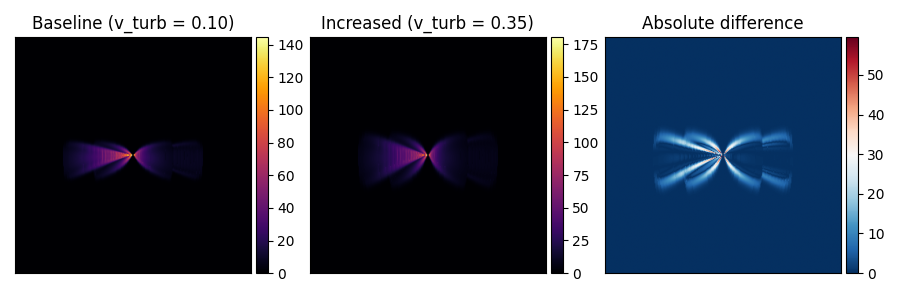

In [12]:
%matplotlib widget
visualization.slider_frame_comparison(
    images1,
    images2,
    title1=f"Baseline (v_turb = {disk_params.v_turb:.2f})",
    title2=f"Increased (v_turb = {v_turb:.2f})",
)

## Animated channel map comparison

(<matplotlib.animation.FuncAnimation at 0x16e91d640>,
 './media/tutorial02-channel-map-comparison.gif')

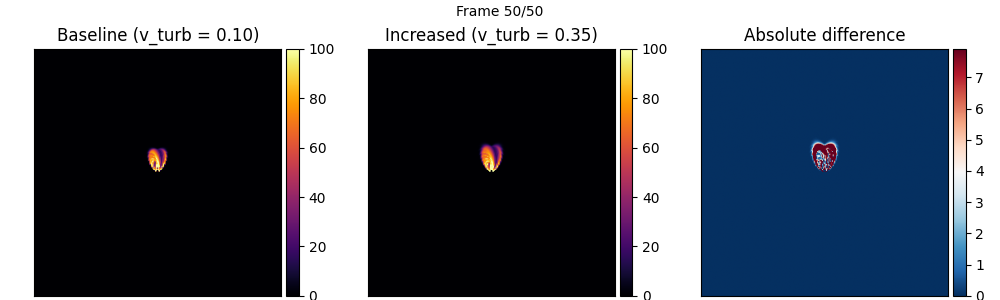

In [14]:
visualization.animate_frame_comparison(
    images1, images2,
    vmin=0.0, vmax=100.0,
    title1=f"Baseline (v_turb = {disk_params.v_turb:.2f})",
    title2=f"Increased (v_turb = {v_turb:.2f})",
    output='./media/tutorial02-channel-map-comparison.gif'
)

![](./media/tutorial02-channel-map-comparison.gif)